#### GETTING THE DATA :

In [4]:
from obsei.source import YoutubeScrapperSource, YoutubeScrapperConfig

In [5]:
video_url = "https://www.youtube.com/watch?v=QuO7GNgCwBk&ab_channel=Forsen%27sGiftbox"
video_url

'https://www.youtube.com/watch?v=QuO7GNgCwBk&ab_channel=Forsen%27sGiftbox'

In [6]:
source_config = YoutubeScrapperConfig(
    video_url= video_url,
    fetch_replies=False,
    max_comments=20,
    lookup_period="1Y",
)

In [8]:
source = YoutubeScrapperSource()

source_response_list = source.lookup(source_config)

09/13/2022 18:56:09 - WARNING - obsei.misc.youtube_reviews_scrapper -   Unable to set sorting


In [9]:

comments = []
likes = []
for idx, source_response in enumerate(source_response_list):
    comments.append(source_response.__dict__['meta']['text'])
    likes.append(source_response.__dict__['meta']['votes'])


In [10]:
print(comments)
print(likes)

['Uhm excuse me what do you mean by "NEW CHAMPION" ? The dead by daylight characters are called Killers Mrs. Giftbox I hope this doesn\'t happen again or you will need some correction', '>Champion\n\nThis is your brain on League of Lesbians.', 'Wesker pagman pogu pog my king 😍😍😍😍', 'new youtube pfp monkaOMEGA', 'Where is part #1. The thumbnail says this is part two but where is part one? Please clarify', 'I was the clicking Chris lule. The bill was in the other locker but I opened the wrong one', 'sweat by daylight PagMan', 'Campsen LULE', 'god gamer dog tamer nina eliminator', 'CHAMPION LULE', 'MegaLUL CAMP EM MR FORS', 'Campsen', 'quality for ants LULE', 'Wesker can get taunts on every other action but not Freddy fucking kreuger sm fucking h', '360sen PagMan', '306p wutface', 'ada wong forsenCoomer', 'God this game is so stupid...']
['24', '40', '35', '31', '10', '1', '12', '9', '0', '2', '1', '5', '4', '0', '2', '4', '2', '5']


In [11]:
import pandas

In [12]:
df = pandas.DataFrame(columns = ["comments","likes"])
df["comments"] = comments
df["likes"] = likes
df

,comments,likes
0,"Uhm excuse me what do you mean by ""NEW CHAMPIO...",24
1,>Champion\n\nThis is your brain on League of L...,40
2,Wesker pagman pogu pog my king 😍😍😍😍,35
3,new youtube pfp monkaOMEGA,31
4,Where is part #1. The thumbnail says this is p...,10
5,I was the clicking Chris lule. The bill was in...,1
6,sweat by daylight PagMan,12
7,Campsen LULE,9
8,god gamer dog tamer nina eliminator,0
9,CHAMPION LULE,2


##### DOWNLOADING TWITTER SENTIMENT PRETRAINED MODEL :

In [13]:
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer
import numpy as np
from scipy.special import softmax
import csv
import urllib.request


In [14]:
# Tasks:
# emoji, emotion, hate, irony, offensive, sentiment
task='sentiment'
MODEL = f"cardiffnlp/twitter-roberta-base-{task}"

In [16]:

tokenizer = AutoTokenizer.from_pretrained(MODEL)
# download label mapping
labels=[]
mapping_link = f"https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/{task}/mapping.txt"
with urllib.request.urlopen(mapping_link) as f:
    html = f.read().decode('utf-8').split("\n")
    csvreader = csv.reader(html, delimiter='\t')
labels = [row[1] for row in csvreader if len(row) > 1]

# PT
model = AutoModelForSequenceClassification.from_pretrained(MODEL)
model.save_pretrained(MODEL)


In [17]:
# Preprocess text (username and link placeholders)
def preprocess(text):
    new_text = []
    for t in text.split(" "):
        t = '@user' if t.startswith('@') and len(t) > 1 else t
        t = 'http' if t.startswith('http') else t
        new_text.append(t)
    return " ".join(new_text)


#### FINETUNING ?

In [54]:
for comment in df.loc[:,"comments"]:
    print(comment)

Uhm excuse me what do you mean by "NEW CHAMPION" ? The dead by daylight characters are called Killers Mrs. Giftbox I hope this doesn't happen again or you will need some correction
>Champion

This is your brain on League of Lesbians.
Wesker pagman pogu pog my king 😍😍😍😍
new youtube pfp monkaOMEGA
Where is part #1. The thumbnail says this is part two but where is part one? Please clarify
I was the clicking Chris lule. The bill was in the other locker but I opened the wrong one
sweat by daylight PagMan
Campsen LULE
god gamer dog tamer nina eliminator
CHAMPION LULE
MegaLUL CAMP EM MR FORS
Campsen
quality for ants LULE
Wesker can get taunts on every other action but not Freddy fucking kreuger sm fucking h
360sen PagMan
306p wutface
ada wong forsenCoomer
God this game is so stupid...


#### USING THE MODEL ON THE DATA :

In [28]:
label_length = len(labels)
print(label_length)
vid_score = [0 for i in range(label_length)]
comment_len = len(df.loc[:, "comments"])

3


In [29]:

for comment in df.loc[:, "comments"]:
    comment = preprocess(comment)
    encoded_input = tokenizer(comment, return_tensors='pt')
    output = model(**encoded_input)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)


    ranking = np.argsort(scores)
    ranking = ranking[::-1]
    for i in range(scores.shape[0]):
        l = labels[ranking[i]]
        s = scores[ranking[i]]
        vid_score[i] += s
        print(f"{i+1}) {l} {np.round(float(s), 4)}")
vid_score = [e/comment_len for e in vid_score]
print(vid_score)

1) negative 0.7322
2) neutral 0.2498
3) positive 0.018
1) neutral 0.5902
2) negative 0.3576
3) positive 0.0522
1) positive 0.966
2) neutral 0.032
3) negative 0.002
1) neutral 0.8307
2) positive 0.1468
3) negative 0.0225
1) neutral 0.7824
2) negative 0.1669
3) positive 0.0507
1) negative 0.5951
2) neutral 0.3715
3) positive 0.0334
1) neutral 0.8599
2) negative 0.0774
3) positive 0.0627
1) neutral 0.7468
2) negative 0.1648
3) positive 0.0884
1) negative 0.5845
2) neutral 0.3919
3) positive 0.0236
1) positive 0.517
2) neutral 0.4443
3) negative 0.0386
1) neutral 0.7893
2) negative 0.1099
3) positive 0.1008
1) neutral 0.6736
2) negative 0.1676
3) positive 0.1587
1) neutral 0.6036
2) negative 0.3445
3) positive 0.0519
1) negative 0.9244
2) neutral 0.0701
3) positive 0.0055
1) neutral 0.7937
2) negative 0.1288
3) positive 0.0775
1) neutral 0.5974
2) negative 0.3548
3) positive 0.0478
1) neutral 0.8435
2) negative 0.1005
3) positive 0.0559
1) negative 0.9807
2) neutral 0.0157
3) positive 0.00

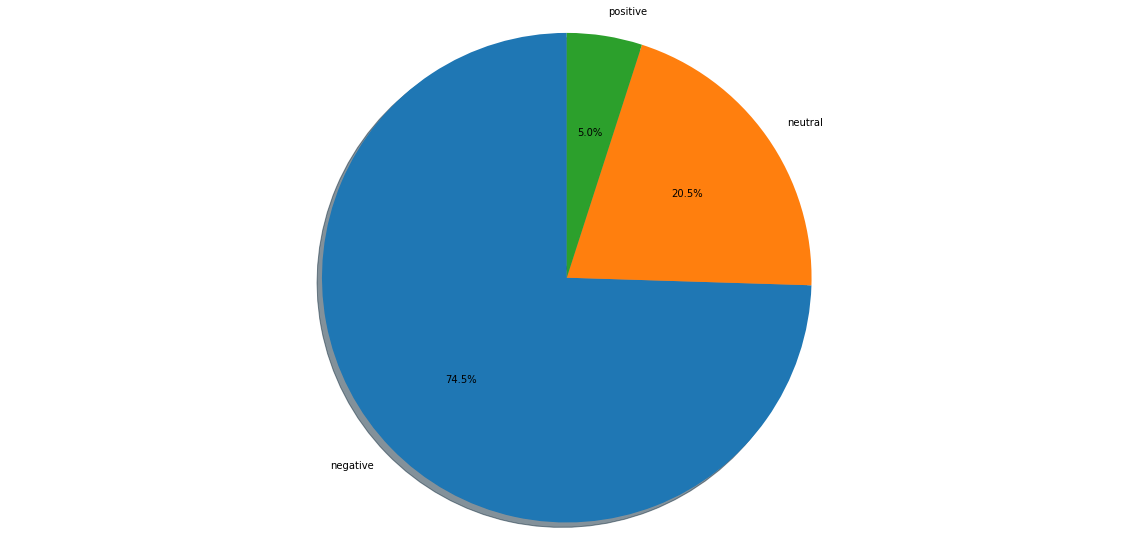

In [33]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 10]
fig1, ax1 = plt.subplots()
ax1.pie(vid_score, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()